In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py
import testCases #参见资料包，或者在文章底部copy
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward #参见资料包
import lr_utils #参见资料包，或者在文章底部copy

In [2]:
np.random.seed(1)

In [3]:
def initialize_parameters(n_x,n_h,n_y):
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters ={
        'W1':W1,
        'b1':b1,
        'W2':W2,
        'b2':b2
    }
    
    return parameters

In [4]:
# 测试initialize_parameters()
parameters = initialize_parameters(3,2,1)
print('W1 = ' + str(parameters['W1']))
print('b1 = ' + str(parameters['b1']))
print('W2 = ' + str(parameters['W2']))
print('b2 = ' + str(parameters['b2']))

W1 = [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1 = [[0.]
 [0.]]
W2 = [[ 0.01744812 -0.00761207]]
b2 = [[0.]]


In [5]:
def initial_parameters_deep(layers_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims)
    
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l - 1]) / np.sqrt(layers_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        
        assert(parameters["W" + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layers_dims[l], 1))
        
    return parameters

In [6]:
# 测试initial_parameters_deep()
layers_dims = [5,4,3]
parameters = initial_parameters_deep(layers_dims)
print('W1 = ' + str(parameters['W1']))
print('b1 = ' + str(parameters['b1']))
print('W2 = ' + str(parameters['W2']))
print('b2 = ' + str(parameters['b2']))

W1 = [[ 0.79989897  0.19521314  0.04315498 -0.83337927 -0.12405178]
 [-0.15865304 -0.03700312 -0.28040323 -0.01959608 -0.21341839]
 [-0.58757818  0.39561516  0.39413741  0.76454432  0.02237573]
 [-0.18097724 -0.24389238 -0.69160568  0.43932807 -0.49241241]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.59252326 -0.10282495  0.74307418  0.11835813]
 [-0.51189257 -0.3564966   0.31262248 -0.08025668]
 [-0.38441818 -0.11501536  0.37252813  0.98805539]]
b2 = [[0.]
 [0.]
 [0.]]


In [7]:
def linear_forward(A,W,b):
    Z = np.dot(W,A) + b
    assert(Z.shape == (W.shape[0],A.shape[1]))
    cache = (A,W,b)
    
    return Z,cache

In [8]:
# 测试line_forward
A,W,b = testCases.linear_forward_test_case()
Z,cache = linear_forward(A,W,b)
print(Z)

[[ 3.26295337 -1.23429987]]


In [9]:
def linear_activation_forward(A_pre,W,b,activation):
    if activation == 'sigmoid':
        Z,linear_cache = linear_forward(A_pre,W,b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == 'relu':
        Z,linear_cache = linear_forward(A_pre,W,b)
        A, activation_cache = relu(Z)
        
    assert(A.shape == (W.shape[0],A_pre.shape[1]))
    cache = (linear_cache,activation_cache)
    return A,cache

In [10]:
# 测试linear_activation_forward
A_pre,W,b = testCases.linear_activation_forward_test_case()

A,linear_cache = linear_activation_forward(A_pre,W,b,'sigmoid')
print('sigmoid A = ' + str(A))

A,linear_cache = linear_activation_forward(A_pre,W,b,'relu')
print('relu A = ' + str(A))

sigmoid A = [[0.96890023 0.11013289]]
relu A = [[3.43896131 0.        ]]


In [11]:
# 模型前n - 1层激活函数都是relu，最后一层是sigmoid函数
def L_model_forward(X,parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1,L):
        A_pre = A
        A,cache = linear_activation_forward(A_pre,parameters['W' + str(l)],parameters['b'+str(l)],'relu')
        caches.append(cache)
        
    AL,cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],'sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
    return AL,caches

In [12]:
# 测试L_model_forward
X,parameters = testCases.L_model_forward_test_case()

AL,caches = L_model_forward(X,parameters)

print('AL = ' + str(AL))
print('cache的长度是：' +str(len(caches)))

AL = [[0.17007265 0.2524272 ]]
cache的长度是：2


In [13]:
# −1/m∑i=1m(y(i)log(a[L](i))+(1−y(i))log(1−a[L](i))）
def compute_cost(AL,Y):
    m = Y.shape[1]
    cost =-np.sum((np.multiply(Y,np.log(AL)) + np.multiply((1 - Y),np.log(1 - AL))))/m
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

In [14]:
#测试compute_cost
Y,AL = testCases.compute_cost_test_case()
cost = compute_cost(AL,Y)
print('cost = ' + str(cost))

cost = 0.414931599615397


In [15]:
def linear_backward(dZ,cache):
    A_pre,W,b = cache
    m = A_pre.shape[1]
    dW = np.dot(dZ,A_pre.T) / m
    db = np.sum(dZ,axis = 1,keepdims=True) / m
    dA_pre = np.dot(W.T,dZ)
    
    assert (dA_pre.shape == A_pre.shape)
    assert(db.shape == b.shape)
    assert(dW.shape == W.shape)
    
    return dA_pre,dW,db

In [16]:
# 测试linear_backward
dZ,cache = testCases.linear_backward_test_case()
dA_pre,dW,db = linear_backward(dZ,cache)
print('dA_pre = ' + str(dA_pre))
print('dW = ' + str(dW))
print('db = ' + str(db))

dA_pre = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[0.50629448]]


In [17]:
def linear_activation_backward(dA,cache,activation = 'relu'):
    linear_cache,activation_cache = cache
    
    if activation == 'relu':
        dZ = relu_backward(dA,activation_cache)
        dA_pre,dW,db = linear_backward(dZ,linear_cache)
    
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA,activation_cache)
        dA_pre,dW,db = linear_backward(dZ,linear_cache)
    
    return dA_pre,dW,db

In [18]:
# 测试linear_activation_backward
dA,cache = testCases.linear_activation_backward_test_case()

dA_pre,dW,db = linear_activation_backward(dA,cache,activation = 'sigmoid')
print('sigmoid :')
print('dA_pre = ' + str(dA_pre))
print('dW = ' +str(dW))
print('db = ' +str(db))

dA_pre,dW,db = linear_activation_backward(dA,cache,activation = 'relu')
print('rule :')
print('dA_pre = ' + str(dA_pre))
print('dW = ' +str(dW))
print('db = ' +str(db))

sigmoid :
dA_pre = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]
rule :
dA_pre = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


In [19]:
def L_model_backward(AL,Y,caches):
    grads = {}
    
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = -(np.divide(Y,AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L - 1]
    grads['dA' + str(L)],grads['dW' + str(L)],grads['db' + str(L)] = linear_activation_backward(dAL,current_cache,'sigmoid')
    
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        grads['dA' + str(l + 1)],grads['dW' + str(l + 1)],grads['db' + str(l + 1)] = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
    return grads

In [20]:
# 测试L_model_backward
AL,Y_assess,caches = testCases.L_model_backward_test_case()

grads = L_model_backward(AL,Y_assess,caches)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dA1 = "+ str(grads["dA1"]))

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]]


In [21]:
def update_parameters(parameters,grads,learning_rate):
    L = len(parameters) // 2
    
    for l in range(L):
        parameters['W' + str(l + 1)]  = parameters['W' + str(l + 1)] - learning_rate * grads['dW' +str(l + 1)]
        parameters['b' + str(l + 1)]  = parameters['b' + str(l + 1)] - learning_rate * grads['db' +str(l + 1)]   
        
    return parameters

In [22]:
# 测试update_parameters
parameters,grads = testCases.update_parameters_test_case()

parameters = update_parameters(parameters,grads,0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


In [23]:
# 搭建两层神经网络
def two_layers_model(X,Y,layers_dims,learning_rate = 0.0075,num_iterations = 3000,print_cost = False,isPlot = True):
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x,n_h,n_y) = layers_dims
    
    parameters = initialize_parameters(n_x,n_h,n_y)
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    for i in range(0,num_iterations):
        # 前向传播
        A1,cache1 = linear_activation_forward(X,W1,b1,'relu')
        A2,cache2 = linear_activation_forward(A1,W2,b2,'sigmoid')
        
        # 计算成本
        cost = compute_cost(A2,Y)
        
        # 初始化后向传播
        dA2 = - (np.divide(Y,A2) - np.divide(1- Y,1 - A2))
        # 后向传播
        dA1,dW2,db2 = linear_activation_backward(dA2,cache2,'sigmoid')
        dA0,dW1,db1 = linear_activation_backward(dA1,cache1,'relu')
        
        ##向后传播完成后的数据保存到grads
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2
        
        # 更新参数
        parameters = update_parameters(parameters, grads,learning_rate)
        
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print('第{}次迭代，cost = {}'.format(i,cost))
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('num_iterations')
        plt.title('learning rate is ' + str(learning_rate))
        plt.show()
        
    return parameters

In [24]:
# 加载数据
train_set_x_ori, train_set_y,test_set_x_ori,test_set_y,classes = lr_utils.load_dataset()

train_x_flattern = train_set_x_ori.reshape(train_set_x_ori.shape[0],-1).T
test_x_flattern = test_set_x_ori.reshape(test_set_x_ori.shape[0], -1).T

train_x = train_x_flattern / 255
train_y = train_set_y
test_x = test_x_flattern / 255
test_y = test_set_y

第0次迭代，cost = 0.6930497356599891
第100次迭代，cost = 0.6464320953428849
第200次迭代，cost = 0.6325140647912677
第300次迭代，cost = 0.6015024920354665
第400次迭代，cost = 0.5601966311605748
第500次迭代，cost = 0.515830477276473
第600次迭代，cost = 0.4754901313943325
第700次迭代，cost = 0.4339163151225749
第800次迭代，cost = 0.4007977536203889
第900次迭代，cost = 0.3580705011323798
第1000次迭代，cost = 0.3394281538366414
第1100次迭代，cost = 0.3052753636196264
第1200次迭代，cost = 0.27491377282130164
第1300次迭代，cost = 0.2468176821061483
第1400次迭代，cost = 0.19850735037466094
第1500次迭代，cost = 0.17448318112556654
第1600次迭代，cost = 0.17080762978096053
第1700次迭代，cost = 0.11306524562164734
第1800次迭代，cost = 0.0962942684593715
第1900次迭代，cost = 0.08342617959726863
第2000次迭代，cost = 0.07439078704319084
第2100次迭代，cost = 0.06630748132267932
第2200次迭代，cost = 0.059193295010381675
第2300次迭代，cost = 0.053361403485605544
第2400次迭代，cost = 0.04855478562877017


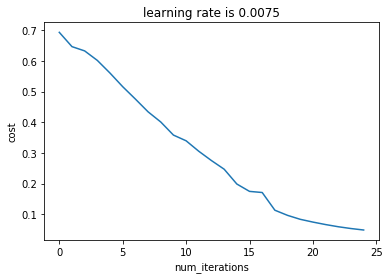

In [25]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x,n_h,n_y)

parameters = two_layers_model(train_x,train_set_y,layers_dims = (n_x, n_h, n_y),num_iterations=2500,print_cost=True,isPlot=True)

In [26]:
def predict(X,y,parameters):
    m =X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    probas,caches = L_model_forward(X,parameters)
    
    for i in range(0,probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
            
    print('准确率 = ' +str((np.sum(p == y) / m)))
    
    return p

In [27]:
predictions_train = predict(train_x, train_y, parameters) #训练集
predictions_test = predict(test_x, test_y, parameters) #测试集

准确率 = 1.0
准确率 = 0.72


In [28]:
def L_layer_model(X,Y,layers_dims,learning_rate = 0.0075,num_iterations = 2500,print_cost = False,isPlot=True):
    np.random.seed(1)
    costs = []
    
    parameters = initial_parameters_deep(layers_dims)
    
    for i in range(0,num_iterations):
        AL,caches = L_model_forward(X,parameters)
        
        cost = compute_cost(AL,Y)
        grads = L_model_backward(AL,Y,caches)
        
        parameters = update_parameters(parameters,grads,learning_rate)
        
        if i % 100 ==0:
            costs.append(cost)
            if print_cost:
                print('第{}次迭代，cost = {}'.format(i,cost))
    
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
    return parameters

第0次迭代，cost = 0.715731513413713
第100次迭代，cost = 0.6747377593469114
第200次迭代，cost = 0.6603365433622127
第300次迭代，cost = 0.6462887802148751
第400次迭代，cost = 0.6298131216927773
第500次迭代，cost = 0.606005622926534
第600次迭代，cost = 0.5690041263975135
第700次迭代，cost = 0.5197965350438059
第800次迭代，cost = 0.46415716786282285
第900次迭代，cost = 0.40842030048298916
第1000次迭代，cost = 0.37315499216069026
第1100次迭代，cost = 0.30572374573047106
第1200次迭代，cost = 0.2681015284774083
第1300次迭代，cost = 0.23872474827672663
第1400次迭代，cost = 0.20632263257914715
第1500次迭代，cost = 0.17943886927493605
第1600次迭代，cost = 0.15798735818801649
第1700次迭代，cost = 0.14240413012274517
第1800次迭代，cost = 0.12865165997888808
第1900次迭代，cost = 0.11244314998164799
第2000次迭代，cost = 0.08505631034983166
第2100次迭代，cost = 0.05758391198617207
第2200次迭代，cost = 0.04456753454699373
第2300次迭代，cost = 0.03808275166600378
第2400次迭代，cost = 0.0344107490184207


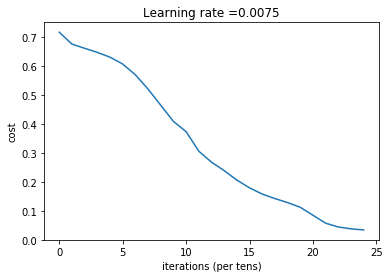

In [29]:
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True,isPlot=True)

In [30]:
pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集

准确率 = 0.9952153110047847
准确率 = 0.78


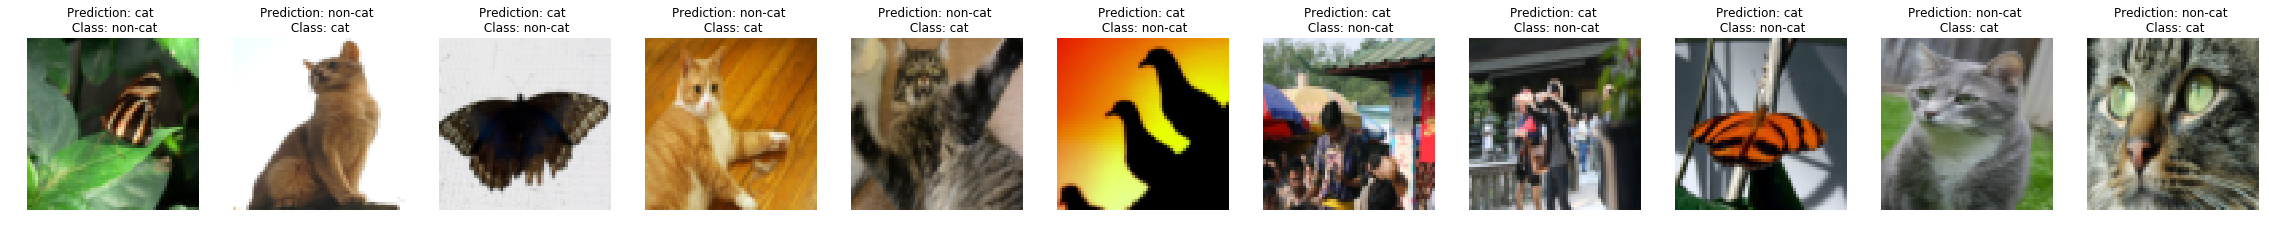

In [31]:
def print_mislabeled_images(classes,X,y,p):
    a = p + y
    mis_labeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mis_labeled_indices[0])
    for i in range(num_images):
        index = mis_labeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))
        
print_mislabeled_images(classes, test_x, test_y, pred_test)

In [36]:
import matplotlib.image as img
import scipy
my_image = '123.jpeg'
my_label_y = [1]

image = np.array(img.imread(my_image))
my_image = scipy.misc.imresize(image,size = (num_px,num_px)).reshape((num_px*num_px*3,1))
# pip3 install Pillow
my_predicted_image = predict(my_image,my_label_y,paramters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

AttributeError: module 'scipy' has no attribute 'misc'